# Sort v Unsort Plaque Analysis

### Plaque Composition Histograms:

QC'd data from ayden

Bar stacked bar plots to show proportions of cell type per plaque per sort type. 

In [1]:
#Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import session_info
import scanpy as sc
from datetime import datetime

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Set up data working directory:
data_path = '/home/jo388/rds/rds-zhao-group-HvBBlpwx4dc/ELLIPSE/sort_unsort/data/'
figure_path = '/home/jo388/rds/rds-zhao-group-HvBBlpwx4dc/ELLIPSE/sort_unsort/figures/'
%matplotlib inline

In [2]:
#Output session Info
session_info.show()

In [3]:
#Output package versions:
sc.logging.print_header()

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.15.0 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.6 pynndescent==0.5.13


In [5]:
#Load Data data:
adata = sc.read_h5ad(data_path + "all_sort_unsort_fine_new_colors.h5ad")

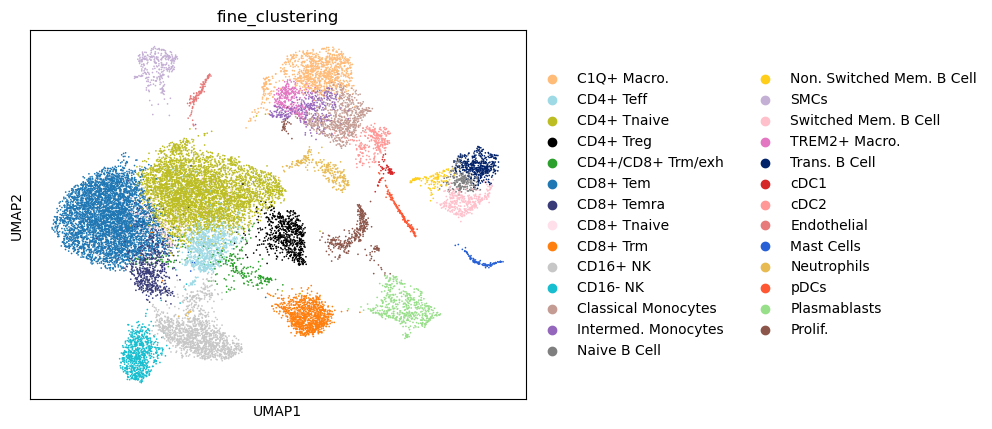

In [6]:
sc.pl.umap(adata, color="fine_clustering")

In [7]:
pd.crosstab(adata.obs['pie_clustering'],
           [adata.obs['plaque'], adata.obs['type']])

plaque                P1              P2              P3              P4  \
type              sorted unsorted sorted unsorted sorted unsorted sorted   
pie_clustering                                                             
B Cells                3       14      6        7     18       26    546   
DCs                    4        8     27       18     31       24     65   
Endothelial Cells      7       71      0        5      2       10      3   
Macro./Mono.          34      269     49      201     90      232    104   
Mast Cells             2       16      1       13      3       22     13   
NK Cells              19       40     36       22     60      112    586   
Neutrophils            0       13      3       15      1        3     12   
Plasmablasts           6       37      2        2     20       66    116   
Prolif.                8       15      5        7     12       16    133   
SMCs                   8       64      3       20      1      115      4   
T Cells              374     1127    426      501    488      592   3388   

plaque                         P5           
type              unsorted sorted unsorted  
pie_clustering                              
B Cells                396     36       57  
DCs                     75     84      138  
Endothelial Cells       12      1        9  
Macro./Mono.           734    137      372  
Mast Cells              20      6       10  
NK Cells               405    346      454  
Neutrophils             84     15      105  
Plasmablasts           263      4        8  
Prolif.                140     13       32  
SMCs                    62      0       37  
T Cells               3572    844     1400

In [8]:
df = pd.crosstab(adata.obs['pie_clustering'],
           [adata.obs['sample'], adata.obs['plaque'], adata.obs['type']]).unstack(level=[0]).reset_index()
df.columns = ['sample', 'plaque', 'type', 'pie_clustering', 'count']
df

,sample,plaque,type,pie_clustering,count
0,P1-US,P1,unsorted,B Cells,14
1,P1-US,P1,unsorted,DCs,8
2,P1-US,P1,unsorted,Endothelial Cells,71
3,P1-US,P1,unsorted,Macro./Mono.,269
4,P1-US,P1,unsorted,Mast Cells,16
...,...,...,...,...,...
105,P5-S,P5,sorted,Neutrophils,15
106,P5-S,P5,sorted,Plasmablasts,4
107,P5-S,P5,sorted,Prolif.,13
108,P5-S,P5,sorted,SMCs,0


In [9]:
# Need to add new column for plotting later:

df['processing'] = np.nan

#If type == unsorted processing = Bead;
df.loc[df['type']=='unsorted', "processing"] = "Bead"

#If type == sorted & plaque = 1,2,or 3 processing = FACS (Authors);
df.loc[(df['type']=='sorted') & (df['plaque'].isin(["P1","P2","P3"])), "processing"] = "FACS (Authors)"

#If type == sorted & plaque = 4 or 5 processing = FACS (Core);
df.loc[(df['type']=='sorted') & (df['plaque'].isin(["P4","P5"])), "processing"] = "FACS (Core)"

df

,sample,plaque,type,pie_clustering,count,processing
0,P1-US,P1,unsorted,B Cells,14,Bead
1,P1-US,P1,unsorted,DCs,8,Bead
2,P1-US,P1,unsorted,Endothelial Cells,71,Bead
3,P1-US,P1,unsorted,Macro./Mono.,269,Bead
4,P1-US,P1,unsorted,Mast Cells,16,Bead
...,...,...,...,...,...,...
105,P5-S,P5,sorted,Neutrophils,15,FACS (Core)
106,P5-S,P5,sorted,Plasmablasts,4,FACS (Core)
107,P5-S,P5,sorted,Prolif.,13,FACS (Core)
108,P5-S,P5,sorted,SMCs,0,FACS (Core)


In [10]:
# Set up R varibales to point to correct conda env:
import os
os.environ['R_HOME'] = '/home/jo388/rds/hpc-work/conda_envs/new_bio/lib/R'
os.environ['R_LIBS_SITE'] = '/home/jo388/rds/hpc-work/conda_envs/new_bio/lib/R/site-library'
os.environ['R_LIBS_USER'] = '/home/jo388/R/x86_64-conda-linux-gnu-library/4.4'

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [11]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In addition: Warning message:
In geom_label(x = 0.5, height = 0.5) :
  Ignoring unknown parameters: `height`


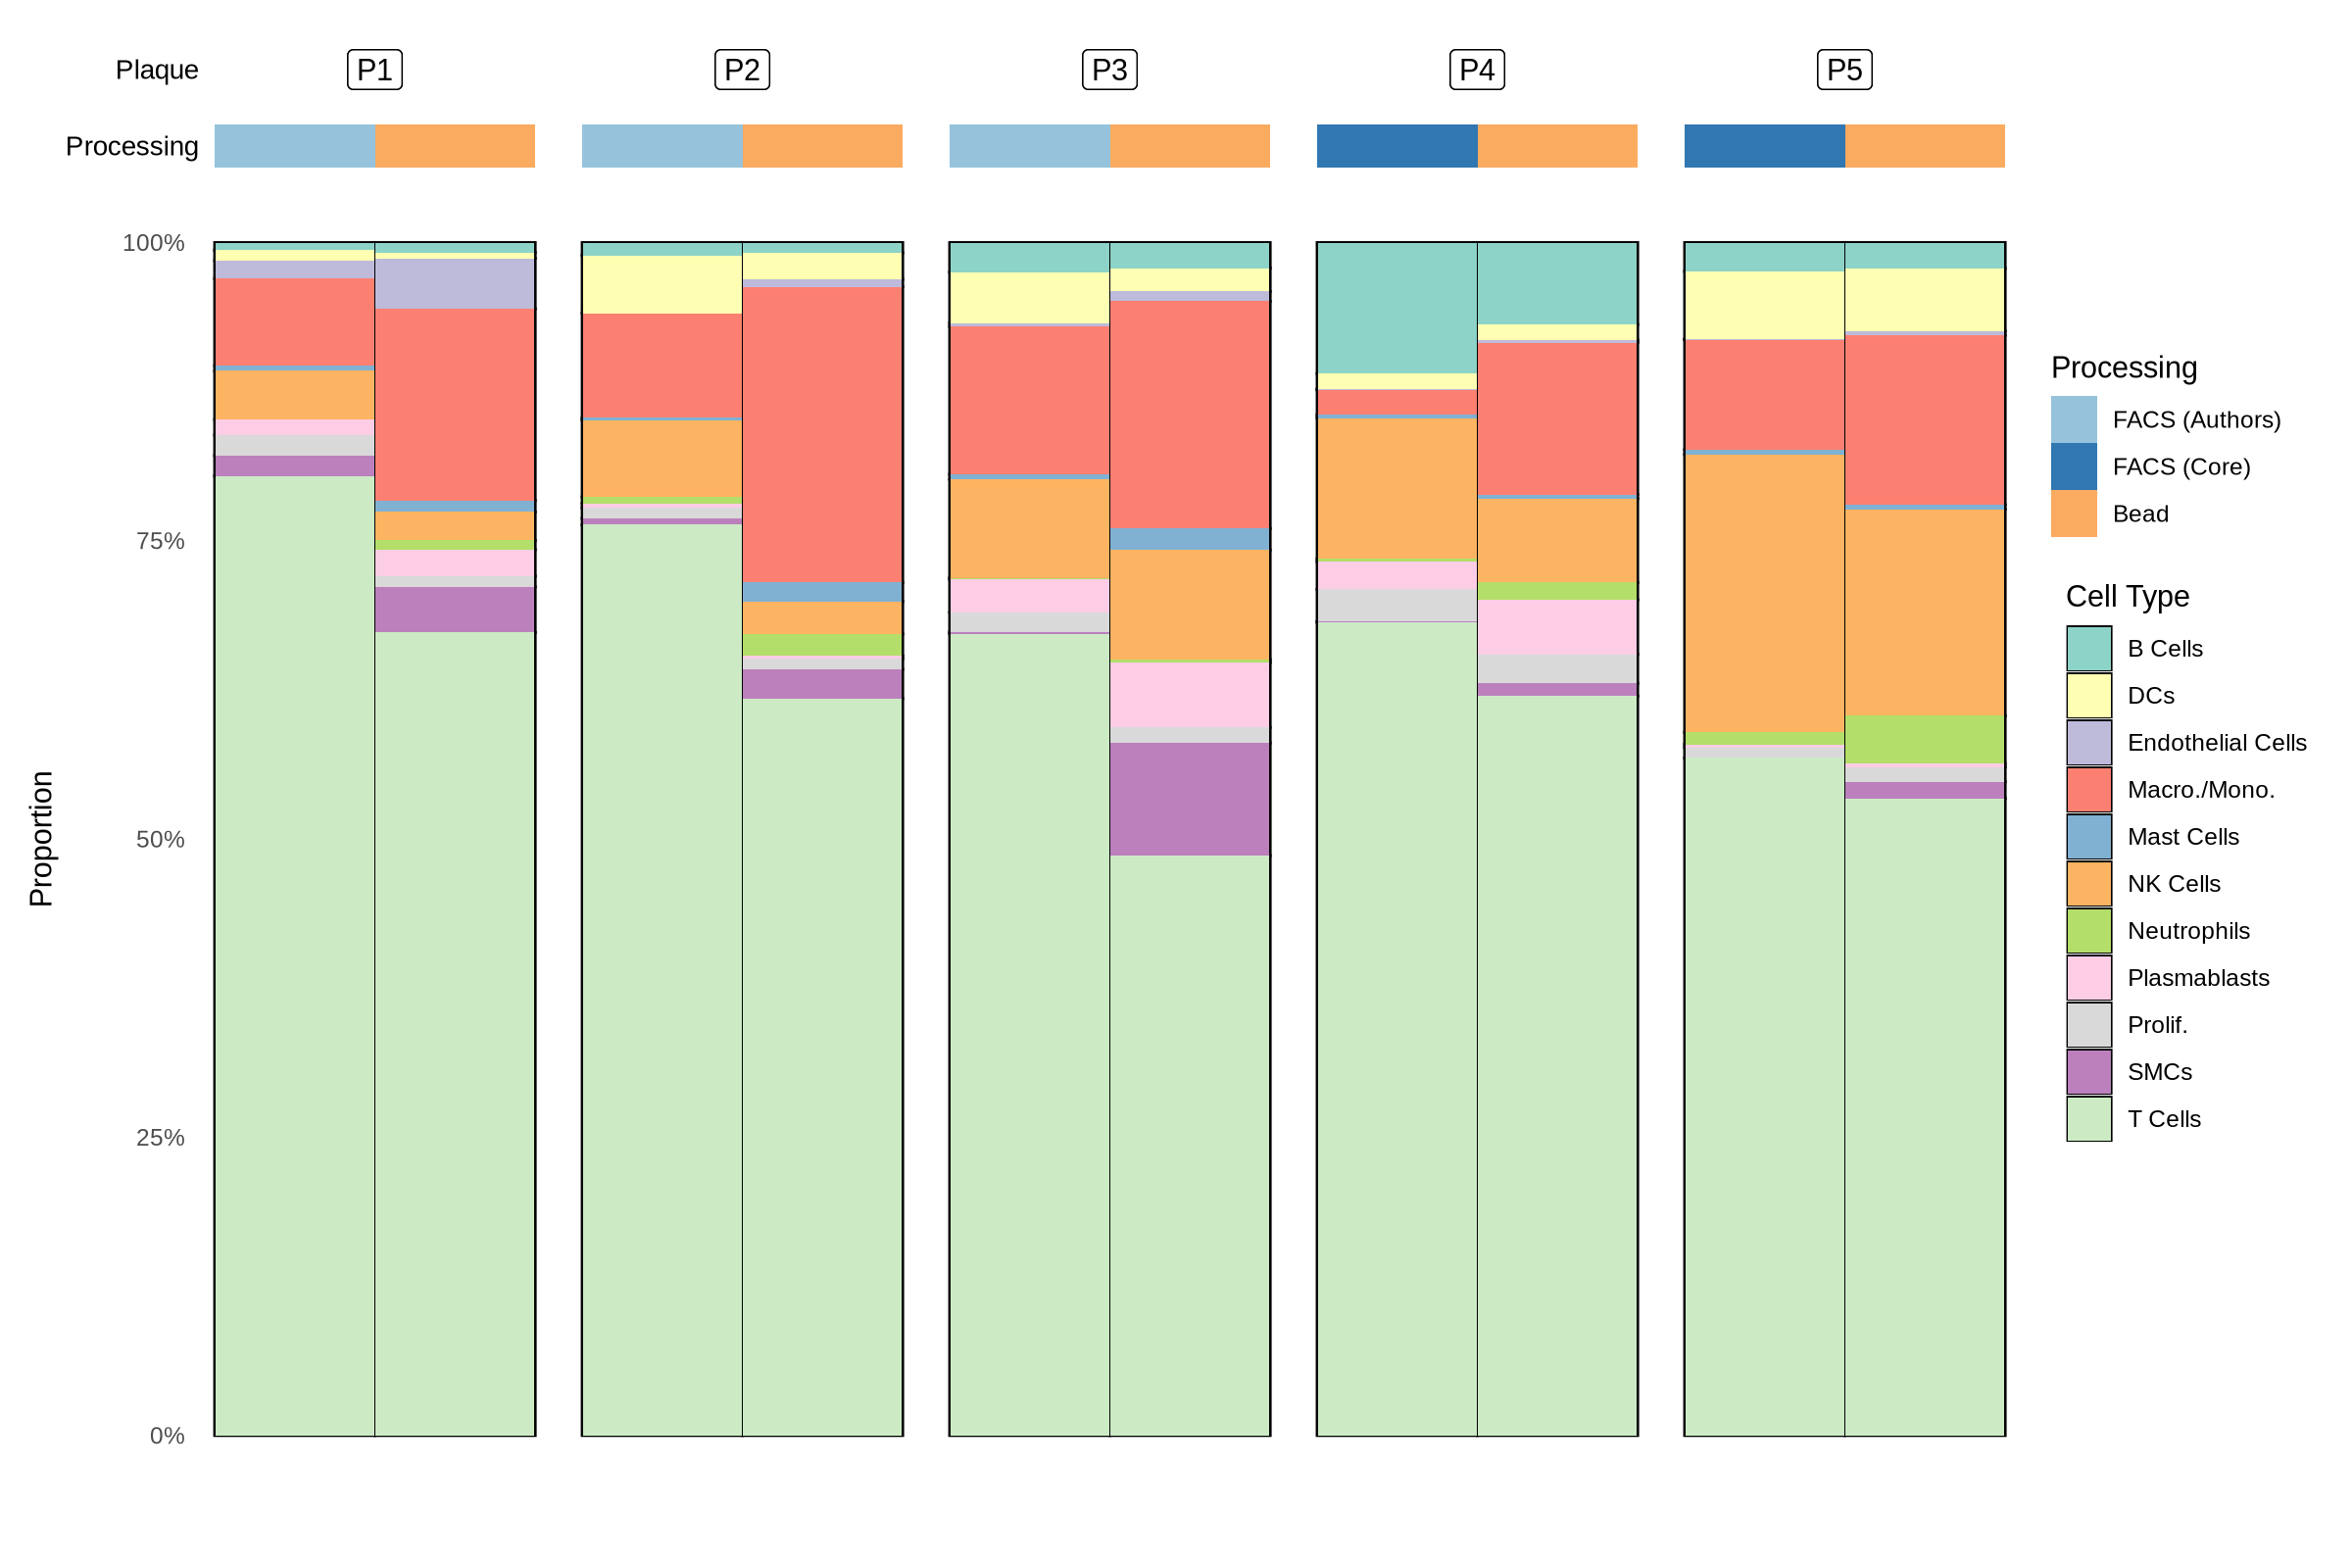

In [13]:
%%R -i df -w 12 -h 8 -u in -r 200

#Updated plot:

df$type <- factor(df$type, level = c("sorted","unsorted"))
df$processing <- factor(df$processing, level = c("FACS (Authors)", "FACS (Core)", "Bead"))

CellCompositionPlot <- ggplot(df, aes(x = type, y = count, fill=pie_clustering)) +
    geom_bar(position="fill", stat="identity", width=1, color="black") +
    geom_bar(position="fill", stat="identity", width=0.99) +
    facet_wrap(~plaque, nrow=1) +
    scale_y_continuous(labels = scales::label_percent(accuracy = 1)) +
    scale_fill_brewer(palette = "Set3") +
    labs(x = "", y = "Proportion", fill = "Cell Type") +
    theme_minimal() +
    theme(strip.background = element_blank(),
          strip.text.x = element_blank(),
          panel.grid.minor = element_blank(),
          panel.grid.major = element_blank(),
         axis.ticks.x = element_blank(),
         axis.text.x = element_blank())

plaque_annotations <- ggplot(df %>% 
  distinct(sample, plaque, type, processing) %>%
  group_by(plaque, type), aes(x=plaque, y='Plaque', label=plaque)) +
  geom_label(x=0.5, height=0.5) +
  facet_wrap(~plaque, nrow=1) + 
  theme_void() +
  theme(axis.title.y = element_blank(),
        axis.text.y = element_text(size = 10, hjust = 0.5),
        axis.ticks.y = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        strip.background = element_blank(),
        strip.text.x = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank())

sort_annotations <- ggplot(df %>% distinct(sample, plaque, type, processing)) +
  geom_tile(aes(x = type, y = "Processing", fill = processing), height = 0.5) +
  scale_y_discrete(expand = c(0, 0)) +
  scale_fill_manual(values = c("FACS (Authors)" = "#96C3DB", "FACS (Core)" = "#3177B1", "Bead" = "#FAAB60")) +
  facet_wrap(~plaque, nrow=1) +
  labs(fill="Processing") +
  theme_void() +
  theme(axis.title.y = element_blank(),
        axis.text.y = element_text(size = 10, hjust = 0.5),
        axis.ticks.y = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        strip.background = element_blank(),
        strip.text.x = element_blank(),
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),)

combined <- plaque_annotations / sort_annotations / CellCompositionPlot + plot_layout(heights = c(0.5, 0.2, 6)) & theme(legend.position = "right")
combined + plot_layout(guides = "collect")


In [14]:
%%R -i figure_path
ggsave(paste0(figure_path, "Sorted v Unsorted Plaque Composition Plots - Updated.pdf"))

Saving 6.67 x 6.67 in image


In [15]:
%%R 
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.10 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /rds/user/jo388/hpc-work/conda_envs/new_bio/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: GB
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] patchwork_1.3.0 tidyr_1.3.1     dplyr_1.1.4     ggplot2_3.5.1  

loaded via a namespace (and not attached):
 [1] vctrs_0.6.5        cli_3.6.3          rlang_1.1.4        purrr_1.0.2       
 [5] 